In [23]:
!pip install vaderSentiment

In [46]:
# 1. Imports
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.utils import class_weight
# 2. Load Dataset
df = pd.read_csv("spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})



In [25]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\d+", "", text)      # remove digits (optional)
    return text.strip()


In [26]:
from sklearn.utils import resample

df_ham = df[df.label == 0]
df_spam = df[df.label == 1]

df_spam_upsampled = resample(df_spam, replace=True, n_samples=int(len(df_ham)*0.8), random_state=42)
df_combined = pd.concat([df_ham, df_spam_upsampled]).sample(frac=1, random_state=42)



In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['text'])
sequences = tokenizer.texts_to_sequences(df_balanced['text'])

X = pad_sequences(sequences, maxlen=100, padding='post')
y = df_balanced['label'].values


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)

model.fit(X_train, y_train, epochs=25, batch_size=32,
          validation_split=0.1)



Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


218/218 ━━━━━━━━━━━━━━━━━━━━ 54s 218ms/step - accuracy: 0.4981 - loss: 0.6945 - val_accuracy: 0.4845 - val_loss: 0.6938
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 78s 200ms/step - accuracy: 0.4999 - loss: 0.6940 - val_accuracy: 0.5168 - val_loss: 0.6928
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 44s 200ms/step - accuracy: 0.5053 - loss: 0.6936 - val_accuracy: 0.5168 - val_loss: 0.6928
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 205ms/step - accuracy: 0.4943 - loss: 0.6938 - val_accuracy: 0.4832 - val_loss: 0.6931
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 81s 201ms/step - accuracy: 0.4943 - loss: 0.6937 - val_accuracy: 0.5168 - val_loss: 0.6927
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 45s 207ms/step - accuracy: 0.5076 - loss: 0.6933 - val_accuracy: 0.4845 - val_loss: 0.6932
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 81s 205ms/step - accuracy: 0.5182 - loss: 0.6931 - val_accuracy: 0.5155 - val_loss: 0.6927
Epoch 8/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 208ms/step - accuracy: 0.4954 - loss: 0.6936 - val

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       975
           1       0.99      1.00      0.99       955

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



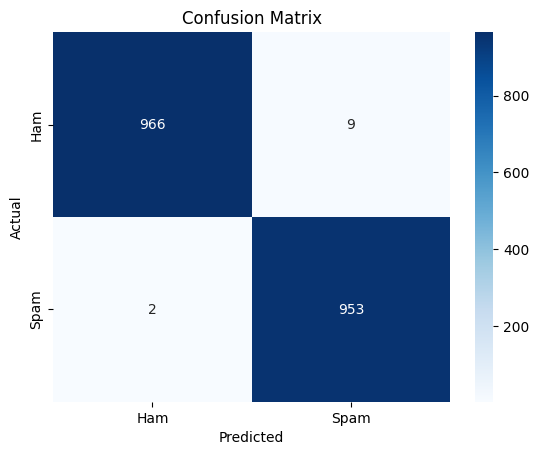

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


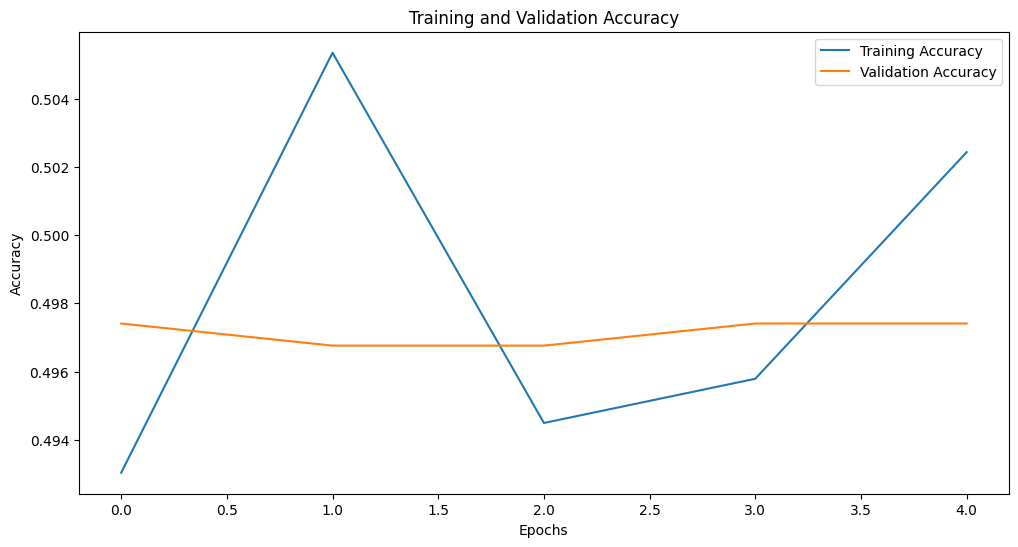

In [36]:
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [40]:
# 1. Install VADER if needed
# !pip install vaderSentiment

# 2. Imports
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 3. Load the data
df = pd.read_csv("spam.csv", encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']

# 4. Clean the text (optional but helps)
import re
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['clean_text'] = df['text'].apply(clean_text)

# 5. Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# 6. Apply sentiment scores
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# 7. Add sentiment column
df['sentiment'] = df['clean_text'].apply(get_sentiment)

# 8. Show sample results
print(df[['text', 'sentiment']].head())


                                                text sentiment
0  Go until jurong point, crazy.. Available only ...  positive
1                      Ok lar... Joking wif u oni...  positive
2  Free entry in 2 a wkly comp to win FA Cup fina...  positive
3  U dun say so early hor... U c already then say...   neutral
4  Nah I don't think he goes to usf, he lives aro...  negative


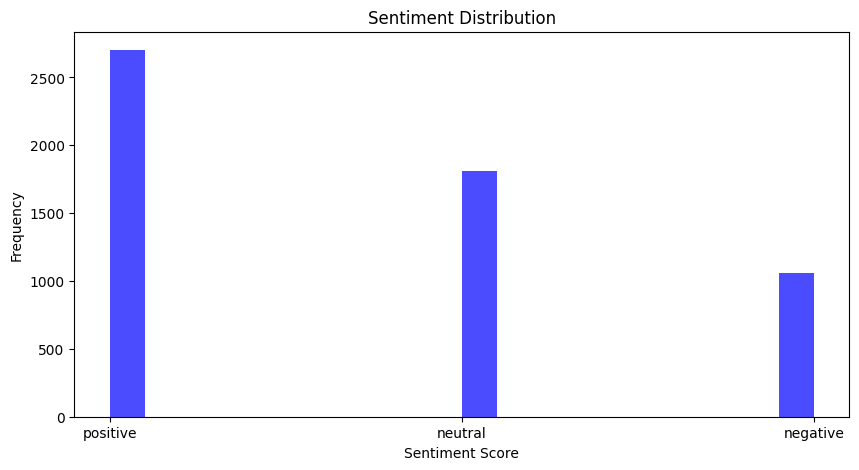

In [41]:
# Visualize sentiment results
plt.figure(figsize=(10, 5))
plt.hist(df['sentiment'], bins=20, color='blue', alpha=0.7)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [43]:

!pip install wordcloud matplotlib

In [47]:
print("Spam count:", df[df['label'] == 1].shape[0])
print("Ham count:", df[df['label'] == 0].shape[0])


Spam count: 747
Ham count: 4825


Text(0.5, 1.0, 'Spam Word Cloud')

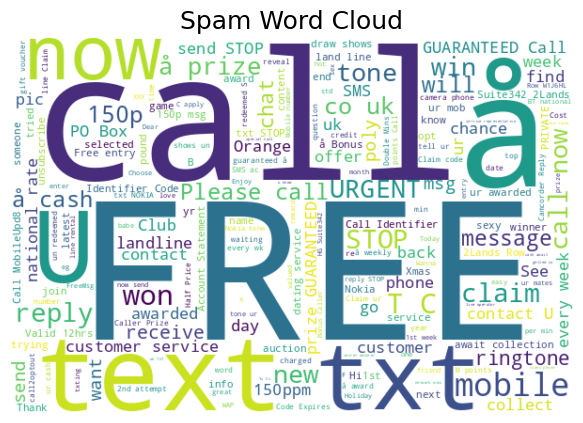

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 3. Separate spam and ham
spam_words = " ".join(df[df['label'] == 1]['text'])
ham_words = " ".join(df[df['label'] == 0]['text'])

# 4. Generate and plot word clouds
plt.figure(figsize=(16, 8))

# Word cloud for spam
plt.subplot(1, 2, 1)
spam_wc = WordCloud(width=600, height=400, background_color='white').generate(spam_words)
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Spam Word Cloud', fontsize=18)

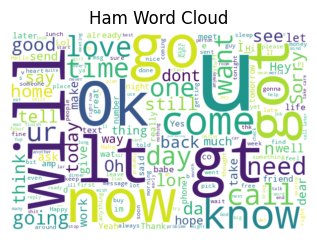

In [50]:
 # Ham WordCloud
plt.subplot(1, 2, 2)
ham_wc = WordCloud(width=600, height=400, background_color='white').generate(ham_words)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Ham Word Cloud")

plt.tight_layout()
plt.show()